In [12]:
import numpy as np
import autograd
import matplotlib.pyplot as plt 

ModuleNotFoundError: No module named 'matplotlib'

# 1. Contour simple

## 1.1.Amorce

Pour s'assurer que l'on trouvera bien un t tel que f(0,t) = c sur l'intervalle [0, 1], on s'appuie sur le théorème des valeurs intermédiaires (la fonction f étant continûment différentiable), et on s'assure que la fonction telle que g(t) = f(0, t) - c change bien de signe sur notre intervalle.
On implémente alors la fonction find_seed qui nous renvoie le t recherché, à epsilon près. La recherche de t est basée sur le principe de dichotomie :

In [3]:
def find_seed(g, x=0, c =0, eps = 2**(-26)):
    """
    trouve la valeur t telle que g(t) = c à epsilon près
    """
    
    gauche = 0
    droite = 1
    
    if (g(x,0)-c)*(g(x,1)-c) > 0 :
        return None
        
    while ((droite-gauche)/2) >= eps :
        milieu = (droite + gauche)/2
        
        if (g(x,droite)-c)*(g(x,milieu)-c)<=0 :
            gauche = milieu
        
        else :
            droite = milieu
    
    return (droite+gauche)/2

## 1.2.Propagation

1.2.1 Première propagation

On va maintenant implémenter une fonction qui renvoie une fraction de ligne de niveau (toujours contenue dans [0, 1]²), sous forme de deux tableaux contenant les abscisses et les ordonnées, en utilisant la fonction find_seed.

In [6]:
def simple_contour1(f, c, delta=0.01) :
    """
    renvoie un fragment de ligne de niveau de valeur c de f
    sou la forme de deux tableaux 
    """
    xo = 0.0
    yo = find_seed(f, xo, c)
    if yo==None :
        return [], []
    X = []
    Y=[]

    while xo <=1 :
        yo = find_seed(f, xo, c)
        if yo != None :
            X.append(xo)
            Y.append(yo)
        xo = xo + delta
    return X, Y           

In [4]:
## Test de notre permière fonction 
def f (x, y) :
    return y**2-x**2

X, Y = simple_contour1(f, 0.2 ) 
Xsec = np.arange(0, 1, 0.01)
Ysec = np.arange(0, 1, 0.01)
Xsec, Ysec = np.meshgrid(Xsec, Ysec)
Z = f(Xsec, Ysec)
plt.axis('equal')
plt.contour(Xsec, Ysec, Z, [0.2])
plt.plot(X,Y, label = 'Ligne de niveau tracée par notre fonction')
plt.legend()
plt.show()

NameError: name 'simple_contour1' is not defined

Notre première fonction présente plusieurs problèmes : 
- Pour une fonction plus complexe, plusieurs solutions pourraient être trouvée par la dichotomie, et on ne peut être certain que l'on obtiendra la bonne.
- La condition d'arrêt suppose que la ligne de niveau atteigne un second bord, ce qui n'est pas forcément la cas...

1.2.2 Deuxième propagation

Commentaire sur l'efficacité de cette méthode
Implémentation d'une seconde méthode avec gradient

In [6]:
def grad_f(x,y) :
    """
    calcule le gradient de f au point (x, y)
    """
    g = autograd.grad
    return np.r_[g(f,0)(x, y), g(f, 1)(x,y)]

def norme_un (vecteur) :
    """
    prend en entrée un vecteur de R² et le rend unitaire
    """
    return [vecteur[0]/(vecteur[0]**2 + vecteur[1]**2)**(1/2), vecteur[1]/(vecteur[0]**2 + vecteur[1]**2)**(1/2)]

def simple_contour2(f, c, delta = 0.01) :
    """
    renvoie un fragment de ligne de niveau de valeur c de f
    sous la forme de deux tableaux 
    """ 
    xo = 0.0
    yo = find_seed (f,xo,c)
    x = [xo]
    y = [yo]
    if yo == None :
        return [], []
    else :
        signe = grad_f(xo, yo)[1]/abs(grad_f(xo, yo)[1])
        vecteur_directeur = norme_un([signe*grad_f(xo, yo)[1], -signe*grad_f(xo, yo)[0]])
        xo = xo + vecteur_directeur[0]*delta
        yo = yo + vecteur_directeur[1]*delta
    while xo <= 1 and yo <= 1 :
        x.append(xo)
        y.append(yo)
        vecteur_directeur = norme_un([signe*grad_f(xo, yo)[1], -signe*grad_f(xo, yo)[0]])
        xo = xo + vecteur_directeur[0]*delta
        yo = yo + vecteur_directeur[1]*delta
    return x, y


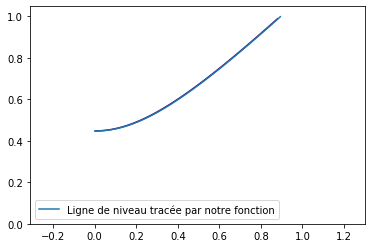

In [14]:
## Test de la deuxième fonction
X, Y = simple_contour2(f, 0.2 ) 
Xsec = np.arange(0, 1, 0.01)
Ysec = np.arange(0, 1, 0.01)
Xsec, Ysec = np.meshgrid(Xsec, Ysec)
Z = f(Xsec, Ysec)
plt.axis('equal')
plt.contour(Xsec, Ysec, Z, [0.2])
plt.plot(X,Y, label = 'Ligne de niveau tracée par notre fonction')
plt.legend()
plt.show()

1.2.3. Troisième propagation 

Nouvelle version améliorée par l'aléatoire

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from random import*

def arc_cercle(vecteur, angle = np.pi/4) :
    rotation1 = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    vecteur1 = np.dot(rotation1 , vecteur)
    rotation2 = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
    vecteur2 = np.dot(rotation2, vecteur)
    return max(vecteur1[0], vecteur2[0])- min(vecteur1[0], vecteur2[0]) 

def max(x, y) :
    if x >= y :
        return x
    else :
        return y

def min(x, y) :
    if x <= y :
        return x
    else :
        return y

def simple_contour3(f, c, delta = 0.01, epsilon = 10**-12) :
    """
    renvoie un fragment de ligne de niveau de valeur c de f
    sous la forme de deux tableaux, sur la même méthode mais en affinant en générant un point aléatoire sur un arc de cercle
    de centre le point précédent, de rayon delta et centré sur le point trouvé par la méthode classique 
    """
    x = []
    y = []
    xo = 0.0
    yo = find_seed (f, xo ,c)
    nouvx = xo
    nouvy=yo
    k = 0 # va compter le nombre de points trouvés sur l ligne de champ
    if yo == None :
        return x, y
    else :
        signe = grad_f(xo, yo)[1]/abs(grad_f(xo, yo)[1])
        x.append(xo)
        y.append(yo)
        k+=1
        vecteur_directeur = norme_un([signe*grad_f(xo, yo)[1], -1*signe*grad_f(xo, yo)[0]])
        xo = xo + vecteur_directeur[0]*delta
        yo = yo + vecteur_directeur[1]*delta        
    while xo <= 1 and yo <= 1 and yo >=0 :
        if abs(f(xo, yo) -c) > epsilon : 
            ## si le point n'est pas satistaisant, 
            ## on en cherche un dans son voisinage, à une distance delta du précédent, aléatoirement
            n = 0 
            while n < 5000 and abs(f(nouvx, nouvy)-c) > epsilon : 
                ## on veille à avoir un programme qui se termine toujours, même dans un cas dégénéré
                n+=1
                nouvx = x[k-1] + random()*(arc_cercle(np.array(vecteur_directeur)))
                nouvy = (abs(nouvx**2 - delta**2))**(1/2)
                if abs(f(nouvx, nouvy)-c) <= abs(f(xo, yo )-c) :
                    xo = nouvx
                    yo = nouvy 
        x.append(xo)
        y.append(yo)
        k+=1
        vecteur_directeur = norme_un([signe*grad_f(xo, yo)[1], -1*signe*grad_f(xo, yo)[0]])
        xo = xo + vecteur_directeur[0]*delta
        yo = yo + vecteur_directeur[1]*delta
    return x, y 
                

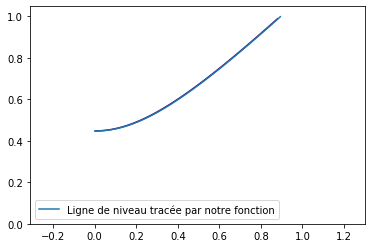

In [59]:
X, Y = simple_contour3(f, 0.2 ) 
Xsec = np.arange(0, 1, 0.01)
Ysec = np.arange(0, 1, 0.01)
Xsec, Ysec = np.meshgrid(Xsec, Ysec)
Z = f(Xsec, Ysec)
plt.axis('equal')
plt.contour(Xsec, Ysec, Z, [0.2])
plt.plot(X,Y, label = 'Ligne de niveau tracée par notre fonction')
plt.legend()
plt.show()

1.2.4. Bonus : application du théorème des fonctions implicites 

In [9]:



def simple_contour4(f,c,delta=0.01):  
    x0=0.0
    y0=find_seed(f,x0,c)
    X=[x0]
    Y=[y0]
    
    
    while x0<=1 and y0<=1:
       
        x0=x0+delta
        y0=y0+(-grad_f(x0,y0)[0]/grad_f(x0,y0)[1])*x0
        X.append(x0)
        Y.append(y0)
    return X, Y


In [11]:
X, Y = simple_contour4(f, 0.2 ) 
Xsec = np.arange(0, 1, 0.01)
Ysec = np.arange(0, 1, 0.01)
Xsec, Ysec = np.meshgrid(Xsec, Ysec)
Z = f(Xsec, Ysec)
plt.axis('equal')
plt.contour(Xsec, Ysec, Z, [0.2])
plt.plot(X,Y, label = 'Ligne de niveau tracée par notre fonction')
plt.legend()
plt.show()


NameError: name 'plt' is not defined

# 2. Contour complexe 

In [13]:
# Rotators
# ------------------------------------------------------------------------------
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise

    
    
        

In [14]:
def rotate_direction(direction, n=1):
    return (direction + n) % 4

In [15]:
def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


In [16]:
def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function


In [17]:
def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour2(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves


In [19]:
 contour(f, 0.2 ) 


[(array([0.        , 0.01      , 0.0199975 , 0.02998753, 0.03996519,
         0.04992573, 0.0598646 , 0.06977747, 0.07966033, 0.08950946,
         0.0993215 , 0.10909342, 0.1188226 , 0.12850674, 0.13814392,
         0.14773258, 0.15727147, 0.16675965, 0.17619647, 0.18558155,
         0.19491473, 0.20419609, 0.21342587, 0.2226045 , 0.23173252,
         0.24081063, 0.24983959, 0.25882029, 0.26775367, 0.2766407 ,
         0.28548244, 0.29427995, 0.30303431, 0.31174664, 0.32041803,
         0.32904961, 0.33764247, 0.3461977 , 0.35471639, 0.3631996 ,
         0.37164838, 0.38006373, 0.38844668, 0.39679818, 0.40511919,
         0.41341063, 0.4216734 , 0.42990838, 0.43811641, 0.44629831,
         0.45445488, 0.46258688, 0.47069506, 0.47878013, 0.4868428 ,
         0.49488373, 0.50290358, 0.51090297, 0.51888251, 0.52684278,
         0.53478435, 0.54270777, 0.55061355, 0.55850222, 0.56637426,
         0.57423014, 0.58207033, 0.58989526, 0.59770537, 0.60550106,
         0.61328273, 0.62105078, 0

In [22]:
level_curves = contour(f, 0.02) 
for x, y in level_curves:
    matplotlib.pyplot.plot(x, y)
    

NameError: name 'matplotlib' is not defined